In [4]:
# setup
import os, pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

plt.rcParams["figure.dpi"] = 140
plt.rcParams["axes.grid"] = True

load_dotenv()
engine = create_engine(os.getenv("DATABASE_URL"))

def q(sql, params=None):
    with engine.begin() as con:
        return pd.read_sql(text(sql), con, params=params)

In [9]:
# Analyse average track features by subgenre
sql = """
SELECT
    st.playlist_subgenre,
    COUNT(*) AS n,
    AVG(st.danceability)::float AS avg_danceability,
    AVG(st.energy)::float AS avg_energy,
    AVG(st.valence)::float AS avg_valence,
    AVG(st.tempo)::float AS avg_tempo,
    AVG(st.loudness)::float AS avg_loudness_db
FROM staging_tracks st
GROUP BY st.playlist_subgenre
ORDER BY n DESC;
"""

df_genre = q(sql)
df_genre.head()

,playlist_subgenre,n,avg_danceability,avg_energy,avg_valence,avg_tempo,avg_loudness_db
0,southern hip hop,3166,0.712627,0.681145,0.554645,118.906871,-6.959708
1,indie poptimism,3094,0.625849,0.637175,0.456226,118.012863,-7.162278
2,neo soul,2956,0.644409,0.540869,0.511833,110.135174,-8.378233
3,progressive electro house,2920,0.653855,0.810262,0.385516,126.290612,-5.801666
4,electro house,2832,0.704478,0.802486,0.429057,125.197134,-5.857287


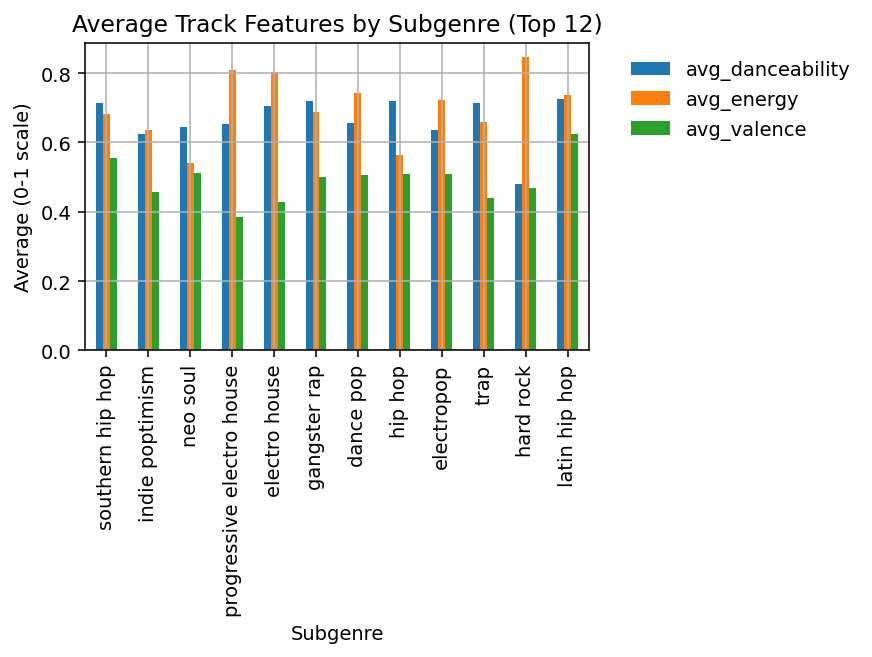

In [13]:
# Plot average features for top 12 subgenres
top = df_genre.sort_values("n", ascending=False).head(12).copy()

ax = top.plot(
    x="playlist_subgenre",
    y=["avg_danceability", "avg_energy", "avg_valence"],
    kind="bar",
)
ax.set_title("Average Track Features by Subgenre (Top 12)")
ax.set_xlabel("Subgenre")
ax.set_ylabel("Average (0-1 scale)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.savefig("../figures/subgenre_feature_profile.png")
plt.show()



In [15]:
# Analyse track popularity percentiles by subgenre
sql = """
SELECT 
    st.playlist_subgenre,
    COUNT(*) AS n,
    PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY st.track_popularity) AS p50_pop,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY st.track_popularity) AS p75_pop,
    PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY st.track_popularity) AS p90_pop
FROM staging_tracks st
WHERE st.playlist_subgenre IS NOT NULL AND st.playlist_subgenre <> ''
GROUP BY st.playlist_subgenre
ORDER BY n DESC;
"""

df_pop = q(sql)
df_pop.head()

,playlist_subgenre,n,p50_pop,p75_pop,p90_pop
0,southern hip hop,3166,37.0,52.0,63.0
1,indie poptimism,3094,44.0,57.0,66.0
2,neo soul,2956,31.0,47.0,58.0
3,progressive electro house,2920,24.0,41.0,51.0
4,electro house,2832,37.0,48.0,57.0


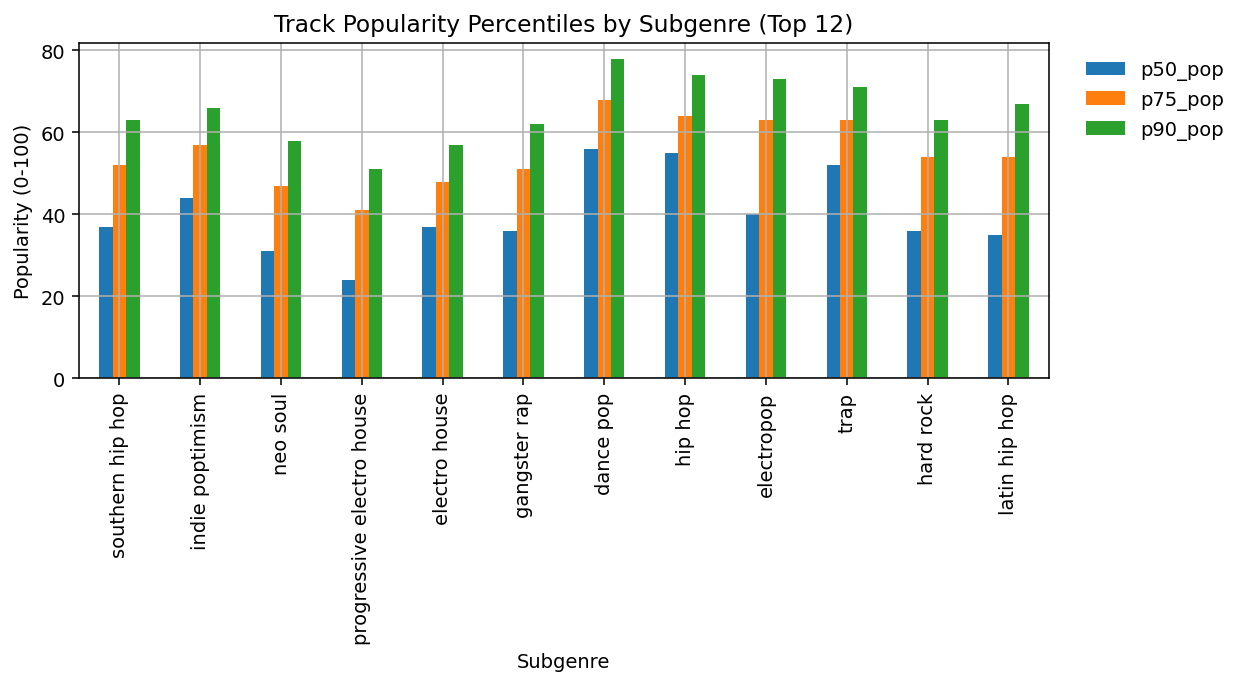

In [ ]:
# Plot track popularity percentiles for top 12 subgenres
top = df_pop.sort_values("n", ascending=False).head(12)

ax = top.plot(
    x="playlist_subgenre",
    y=["p50_pop", "p75_pop", "p90_pop"],
    kind="bar",
    figsize=(9,5)
)
ax.set_title("Track Popularity Percentiles by Subgenre (Top 12)")
ax.set_xlabel("Subgenre")
ax.set_ylabel("Popularity (0-100)")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.savefig("../figures/subgenre_popularity_distribution.png", bbox_inches="tight")
plt.show()



In [ ]:
# Analyse track key and mode distribution
sql = """
SELECT key, mode, COUNT(*) AS n
FROM tracks
GROUP BY key, mode
ORDER BY n DESC;
"""

df_keys = q(sql)

def key_names():
    return ["C", "C#/Db", "D", "D#/Eb", "E", "F", "F#/Gb", "G", "G#/Ab", "A", "A#/Bb", "B"]

def key_label(row):
    try:
        base = key_names()[int(row["key"]) % 12]
        mode_name = "major" if int(row["mode"]) == 1 else "minor"
        return f"{base} {mode_name}"
    except Exception:
        return "Unknown"
    
df_keys["label"] = df_keys.apply(key_label, axis=1)
df_keys.head()




,key,mode,n,label
0,1,1,2274,C#/Db major
1,0,1,2207,C major
2,7,1,2127,G major
3,2,1,1920,D major
4,11,0,1614,B minor
